#### Internshala IMDb Movie Review Sentiment Analysis

Video Explanation link: https://drive.google.com/file/d/1OVgYMFm_l9VzibIRjQ2XXgtvyNi9YQc8/view?usp=sharing

In [5]:
# Data handling
import pandas as pd
import numpy as np
import re
import joblib
import nltk
import xgboost as xgb

# NLP tools
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# ML models
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation metrics and plots
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# nltk downloads
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\danis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
# Load your IMDb dataset (replace filename if different)
df = pd.read_excel('Imdb.xlsx')  

# Standardize label column
df['sentiment'] = df['sentiment'].astype(str)
print(df.head())


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


review            0
sentiment         0
cleaned_review    0
dtype: int64
count    50000.000000
mean       231.137900
std        171.339334
min          1.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: review_length, dtype: float64


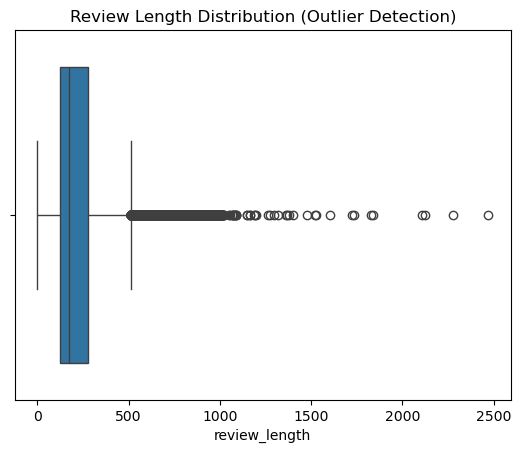

In [23]:
# Check for missing values
print(df.isnull().sum())

# Drop missing rows if any
df.dropna(inplace=True)

# Check basic stats
df['review_length'] = df['review'].apply(lambda x: len(str(x).split()))
print(df['review_length'].describe())

# Visualize outlier reviews (extremely short/long)
sns.boxplot(x=df['review_length'])
plt.title("Review Length Distribution (Outlier Detection)")
plt.show()


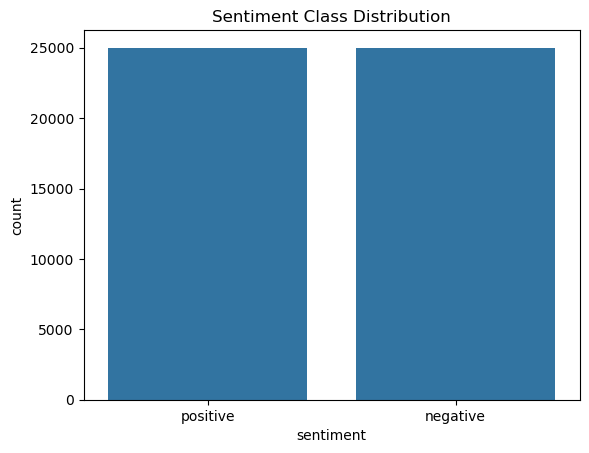

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [142]:
# Class Distribution
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment Class Distribution")
plt.show()

# Display imbalance info
print(df['sentiment'].value_counts())


In [143]:
#Counting characters, word_count and avg_word_length

df['char_count'] = df['review'].apply(len)
df['word_count'] = df['review'].apply(lambda x: len(str(x).split()))
df['avg_word_length'] = df['review'].apply(lambda x: np.mean([len(word) for word in x.split()]))

df[['char_count', 'word_count', 'avg_word_length']].describe()


,char_count,word_count,avg_word_length
count,50000.000000,50000.000000,50000.000000
mean,1309.946840,231.137900,4.642552
std,990.682402,171.339334,0.342278
min,7.000000,1.000000,1.239865
25%,699.000000,126.000000,4.418605
50%,971.000000,173.000000,4.628571
75%,1591.000000,280.000000,4.849414
max,13704.000000,2470.000000,12.290909


In [7]:
#Performing Lemmatization for better balance of cleaned data
def preprocess_review(review_text):
    review_text = review_text.lower()
    review_text = re.sub(r'[^a-zA-Z\s]', '', review_text)
    words = review_text.split()
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)

df['cleaned_review'] = df['review'].apply(preprocess_review)
df.head()

,review,sentiment,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,one reviewer mentioned watching oz episode you...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production br br filming tech...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love time money visually stunni...


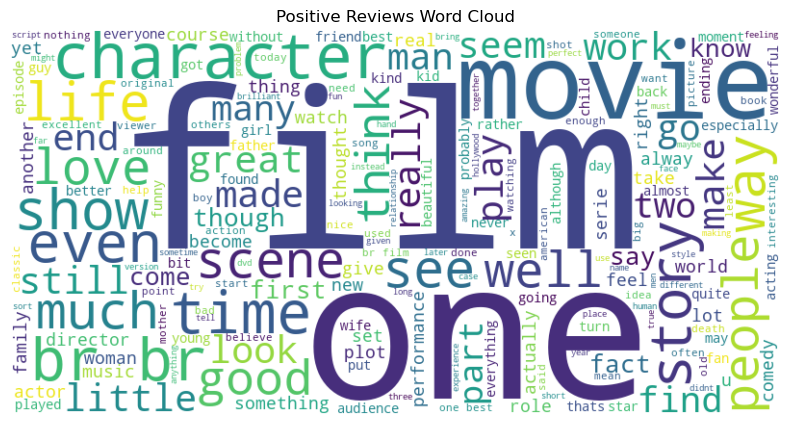

In [153]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Positive Word Cloud
positive_reviews = " ".join(df[df['sentiment'].str.lower().str.strip() == 'positive']['cleaned_review'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_reviews)

#Plotting WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews Word Cloud')
plt.show()

In [149]:
print(df['sentiment'].unique())

['positive' 'negative']


In [8]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_review'])

In [9]:
#Splitting the data into Training and Testing
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, df['sentiment'], test_size=0.2, random_state=42)


In [24]:
# Logistic Regression
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)
y_pred_lr = lr_model.predict(X_test_tfidf)

# Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)

# SVM
svm_model = LinearSVC()
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)

# Random Forest
rf_model = RandomForestClassifier()
rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)


In [11]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
label_encoder = LabelEncoder()

# Fit on full dataset
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [13]:
from xgboost import XGBClassifier

# Train XGBoost on TF-IDF
xgb_model_tfidf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model_tfidf.fit(X_train_tfidf, y_train_encoded)

# Predict
y_pred_xgb_tfidf = xgb_model_tfidf.predict(X_test_tfidf)
y_prob_xgb_tfidf = xgb_model_tfidf.predict_proba(X_test_tfidf)[:, 1]

C:\Users\danis\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:34:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [26]:
results = []

results.append({
    'Model': 'Logistic Regression (TF-IDF)',
    'Accuracy': accuracy_score(y_test, y_pred_lr),
    'F1 Score': f1_score(y_test, y_pred_lr, pos_label='positive'),
    'ROC-AUC': roc_auc_score((y_test == 'positive').astype(int), lr_model.predict_proba(X_test_tfidf)[:, 1])})

results.append({
    'Model': 'Naive Bayes (TF-IDF)',
    'Accuracy': accuracy_score(y_test, y_pred_nb),
    'F1 Score': f1_score(y_test, y_pred_nb, pos_label='positive'),
    'ROC-AUC': roc_auc_score((y_test == 'positive').astype(int), nb_model.predict_proba(X_test_tfidf)[:, 1])})

results.append({
    'Model': 'SVM (TF-IDF)',
    'Accuracy': accuracy_score(y_test, y_pred_svm),
    'F1 Score': f1_score(y_test, y_pred_svm, pos_label='positive'),
    'ROC-AUC': 'NA'})

results.append({
    'Model': 'Random Forest (TF-IDF)',
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'F1 Score': f1_score(y_test, y_pred_rf, pos_label='positive'),
    'ROC-AUC': roc_auc_score((y_test == 'positive').astype(int), rf_model.predict_proba(X_test_tfidf)[:, 1])})

results.append({
    'Model': 'XGBoost (TF-IDF)',
    'Accuracy': accuracy_score(y_test_encoded, y_pred_xgb_tfidf),
    'F1 Score': f1_score(y_test_encoded, y_pred_xgb_tfidf),
    'ROC-AUC': roc_auc_score(y_test_encoded, y_prob_xgb_tfidf)
})

df_results = pd.DataFrame(results)
print(df_results)


                          Model  Accuracy  F1 Score   ROC-AUC
0  Logistic Regression (TF-IDF)    0.8883  0.890522  0.958633
1          Naive Bayes (TF-IDF)    0.8580  0.860730  0.933334
2                  SVM (TF-IDF)    0.8814  0.883382        NA
3        Random Forest (TF-IDF)    0.8521  0.851967  0.932131
4              XGBoost (TF-IDF)    0.8604  0.863858  0.937714


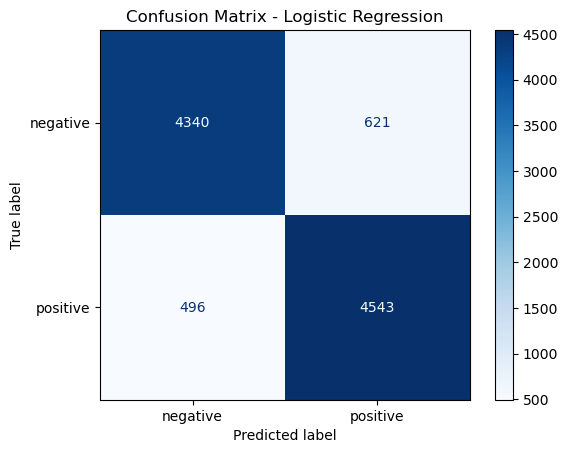

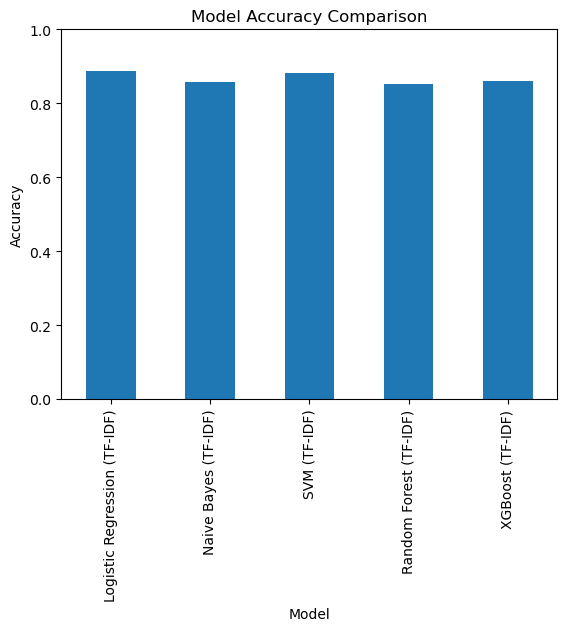

In [27]:
# Example for Logistic Regression
cm = confusion_matrix(y_test, y_pred_lr)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model.classes_).plot(cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

# Bar Plot for Performance Comparison
df_results.plot(kind='bar', x='Model', y='Accuracy', legend=False)
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('Model Accuracy Comparison')
plt.show()

# Word2Vec 

In [17]:
!pip install gensim

import gensim
from gensim.models import Word2Vec
import numpy as np


In [15]:
# Tokenize cleaned reviews for Word2Vec
tokenized_reviews = df['cleaned_review'].apply(lambda x: x.split()).tolist()

In [18]:
# Train Word2Vec Model
w2v_model = Word2Vec(sentences=tokenized_reviews, vector_size=100, window=5, min_count=1, workers=4)

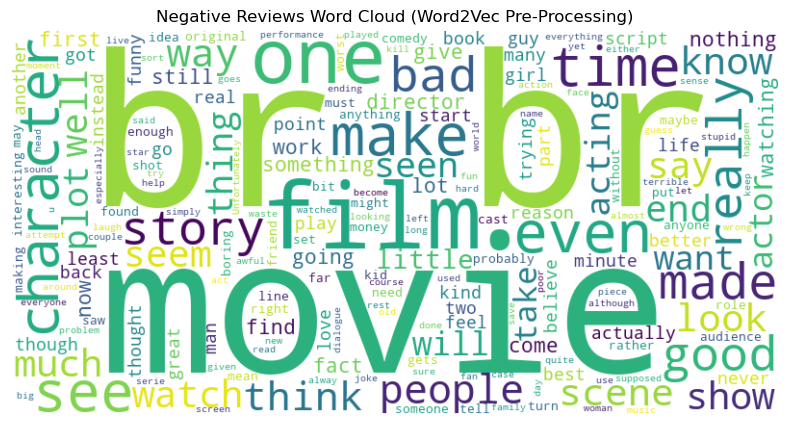

In [170]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Word Cloud for Negative Reviews (Word2Vec Visualization)
negative_reviews = " ".join(df[df['sentiment'].str.lower().str.strip() == 'negative']['review'])

wordcloud_neg = WordCloud(width=800, height=400, background_color='white').generate(negative_reviews)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews Word Cloud (Word2Vec Pre-Processing)')
plt.show()


In [19]:
def vectorize_review(review, model, vector_size):
    vectors = [model.wv[word] for word in review if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(vector_size)
    return np.mean(vectors, axis=0)

# Apply to all reviews
review_vectors = np.array([vectorize_review(review, w2v_model, 100) for review in tokenized_reviews])

In [20]:
X_train_w2v, X_test_w2v, y_train, y_test = train_test_split(review_vectors, df['sentiment'], test_size=0.2, random_state=42)

In [28]:
# Logistic Regression
lr_model_w2v = LogisticRegression(max_iter=1000)
lr_model_w2v.fit(X_train_w2v, y_train)
y_pred_lr_w2v = lr_model_w2v.predict(X_test_w2v)

# SVM
svm_model_w2v = LinearSVC()
svm_model_w2v.fit(X_train_w2v, y_train)
y_pred_svm_w2v = svm_model_w2v.predict(X_test_w2v)

# Random Forest
rf_model_w2v = RandomForestClassifier()
rf_model_w2v.fit(X_train_w2v, y_train)
y_pred_rf_w2v = rf_model_w2v.predict(X_test_w2v)

In [21]:
# For Word2vec
# Train XGBoost on Word2Vec
xgb_model_w2v = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model_w2v.fit(X_train_w2v, y_train_encoded)

# Predict
y_pred_xgb_w2v = xgb_model_w2v.predict(X_test_w2v)
y_prob_xgb_w2v = xgb_model_w2v.predict_proba(X_test_w2v)[:, 1]

C:\Users\danis\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [13:40:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Neural Network Model
model_nn = Sequential([
    Dense(128, activation='relu', input_dim=100),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Convert y_train to binary (if needed)
y_train_nn = (y_train == 'positive').astype(int)
y_test_nn = (y_test == 'positive').astype(int)

# Train NN
model_nn.fit(X_train_w2v, y_train_nn, epochs=10, batch_size=32, validation_split=0.1)

# Predict
y_pred_nn_prob = model_nn.predict(X_test_w2v)
y_pred_nn = (y_pred_nn_prob > 0.5).astype(int).flatten()

C:\Users\danis\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.7864 - loss: 0.4463 - val_accuracy: 0.8590 - val_loss: 0.3324
Epoch 2/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8443 - loss: 0.3607 - val_accuracy: 0.8618 - val_loss: 0.3227
Epoch 3/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8509 - loss: 0.3510 - val_accuracy: 0.8643 - val_loss: 0.3173
Epoch 4/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8519 - loss: 0.3442 - val_accuracy: 0.8645 - val_loss: 0.3237
Epoch 5/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8520 - loss: 0.3422 - val_accuracy: 0.8675 - val_loss: 0.3129
Epoch 6/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8550 - loss: 0.3329 - val_accuracy: 0.8635 - val_loss: 0.3141
Epoch 7/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8571 - loss: 0.3372 - val_accuracy: 0.8618 - val_loss: 0.3150
Epoch 8/10
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8593 - loss: 0.3

In [169]:
from sklearn.metrics import accuracy_score, f1_score

# Logistic Regression
print("Word2Vec + Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr_w2v))

# SVM
print("Word2Vec + SVM Accuracy:", accuracy_score(y_test, y_pred_svm_w2v))

# Random Forest
print("Word2Vec + Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf_w2v))

# Neural Network
print("Word2Vec + Feedforward NN Accuracy:", accuracy_score(y_test_nn, y_pred_nn))

Word2Vec + Logistic Regression Accuracy: 0.8569
Word2Vec + SVM Accuracy: 0.8567
Word2Vec + Random Forest Accuracy: 0.8358
Word2Vec + Feedforward NN Accuracy: 0.8576


In [34]:
# Ensure: y_test_encoded holds 0/1 labels

results_w2v = []

# Logistic Regression (Word2Vec)
y_pred_lr_w2v_numeric = label_encoder.transform(y_pred_lr_w2v)
results_w2v.append({
    'Model': 'Logistic Regression (Word2Vec)',
    'Accuracy': accuracy_score(y_test_encoded, y_pred_lr_w2v_numeric),
    'F1 Score': f1_score(y_test_encoded, y_pred_lr_w2v_numeric),
    'ROC-AUC': roc_auc_score(y_test_encoded, lr_model_w2v.predict_proba(X_test_w2v)[:, 1])
})

# SVM (Word2Vec)
y_pred_svm_w2v_numeric = label_encoder.transform(y_pred_svm_w2v)
results_w2v.append({
    'Model': 'SVM (Word2Vec)',
    'Accuracy': accuracy_score(y_test_encoded, y_pred_svm_w2v_numeric),
    'F1 Score': f1_score(y_test_encoded, y_pred_svm_w2v_numeric),
    'ROC-AUC': 'NA'
})

# Random Forest (Word2Vec)
y_pred_rf_w2v_numeric = label_encoder.transform(y_pred_rf_w2v)
results_w2v.append({
    'Model': 'Random Forest (Word2Vec)',
    'Accuracy': accuracy_score(y_test_encoded, y_pred_rf_w2v_numeric),
    'F1 Score': f1_score(y_test_encoded, y_pred_rf_w2v_numeric),
    'ROC-AUC': roc_auc_score(y_test_encoded, rf_model_w2v.predict_proba(X_test_w2v)[:, 1])
})

# XGBoost (Word2Vec)
y_pred_xgb_w2v_numeric = y_pred_xgb_w2v  # Already numeric
results_w2v.append({
    'Model': 'XGBoost (Word2Vec)',
    'Accuracy': accuracy_score(y_test_encoded, y_pred_xgb_w2v_numeric),
    'F1 Score': f1_score(y_test_encoded, y_pred_xgb_w2v_numeric),
    'ROC-AUC': roc_auc_score(y_test_encoded, y_prob_xgb_w2v)
})

# Feedforward Neural Network (Word2Vec)
results_w2v.append({
    'Model': 'Feedforward NN (Word2Vec)',
    'Accuracy': accuracy_score(y_test_nn, y_pred_nn),
    'F1 Score': f1_score(y_test_nn, y_pred_nn),
    'ROC-AUC': roc_auc_score(y_test_nn, y_pred_nn_prob)
})

# Create Word2Vec Results DataFrame
df_results_w2v = pd.DataFrame(results_w2v).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

# Display Word2Vec Metrics Table
print(df_results_w2v)


                            Model  Accuracy  F1 Score   ROC-AUC
0       Feedforward NN (Word2Vec)    0.8601  0.865416  0.934568
1  Logistic Regression (Word2Vec)    0.8559  0.858099  0.930845
2                  SVM (Word2Vec)    0.8558  0.858183        NA
3              XGBoost (Word2Vec)    0.8465  0.848873  0.924971
4        Random Forest (Word2Vec)    0.8326  0.835592  0.909045


C:\Users\danis\AppData\Local\Temp\ipykernel_13188\3599136529.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=df_results_w2v, palette='coolwarm')


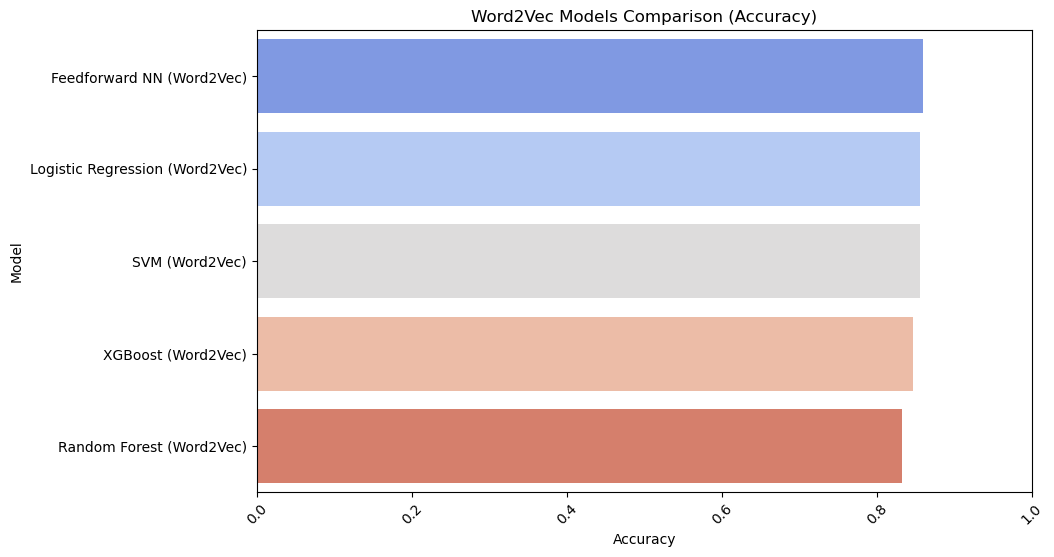

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Model', data=df_results_w2v, palette='coolwarm')
plt.title('Word2Vec Models Comparison (Accuracy)')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.xlim(0, 1)
plt.xticks(rotation=45)
plt.show()

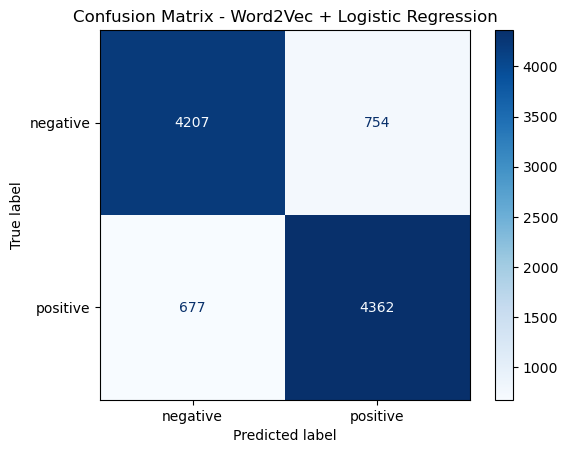

In [171]:
cm = confusion_matrix(y_test, y_pred_lr_w2v)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr_model_w2v.classes_).plot(cmap='Blues')
plt.title('Confusion Matrix - Word2Vec + Logistic Regression')
plt.show()

In [38]:
# Feed farward Neural Network using TF-IDF
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Convert labels for neural network
y_train_nn = (y_train == 'positive').astype(int)
y_test_nn = (y_test == 'positive').astype(int)

# Define FNN using TF-IDF vectors
model_fnn_tfidf = Sequential([
    Dense(512, activation='relu', input_dim=X_train_tfidf.shape[1]),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model_fnn_tfidf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
model_fnn_tfidf.fit(X_train_tfidf.toarray(), y_train_nn, epochs=10, batch_size=64, validation_split=0.1)


C:\Users\danis\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 23s 31ms/step - accuracy: 0.8192 - loss: 0.3910 - val_accuracy: 0.8865 - val_loss: 0.2741
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.9190 - loss: 0.2024 - val_accuracy: 0.8827 - val_loss: 0.2854
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.9595 - loss: 0.1180 - val_accuracy: 0.8832 - val_loss: 0.3630
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.9921 - loss: 0.0296 - val_accuracy: 0.8785 - val_loss: 0.4669
Epoch 5/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.9989 - loss: 0.0060 - val_accuracy: 0.8758 - val_loss: 0.6170
Epoch 6/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.9995 - loss: 0.0024 - val_accuracy: 0.8808 - val_loss: 0.7594
Epoch 7/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 17s 30ms/step - accuracy: 0.9997 - loss: 0.0012 - val_accuracy: 0.8775 - val_loss: 0.7720
Epoch 8/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.9993 - loss: 0.0024 - 

In [39]:
# Predict on test set
y_pred_fnn_prob = model_fnn_tfidf.predict(X_test_tfidf.toarray())
y_pred_fnn = (y_pred_fnn_prob > 0.5).astype(int).flatten()

# Accuracy
from sklearn.metrics import accuracy_score
print("Feedforward NN (TF-IDF) Accuracy:", accuracy_score(y_test_nn, y_pred_fnn))


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Feedforward NN (TF-IDF) Accuracy: 0.88


In [177]:

'''As I am running in Local Jupyter Notebook, It needs GPU and greater memory space to process so,
I have excluded LSTM.'''


## Prepare Data for LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Map words to vectors to build sequences
def get_sequence_embeddings(review, model, vector_size=100):
    vectors = [model.wv[word] for word in review if word in model.wv]
    return vectors

# Create sequences (list of word vectors)
sequence_vectors = [get_sequence_embeddings(review, w2v_model, 100) for review in tokenized_reviews]

# Pad sequences
max_length = max(len(seq) for seq in sequence_vectors)
padded_sequences = pad_sequences(sequence_vectors, maxlen=max_length, dtype='float32', padding='post', truncating='post', value=0.0)

# Train-Test Split
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    padded_sequences, df['sentiment'], test_size=0.2, random_state=42)

# Convert labels to binary
y_train_seq_bin = (y_train_seq == 'positive').astype(int)
y_test_seq_bin = (y_test_seq == 'positive').astype(int)

KeyboardInterrupt: 

In [40]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Ensure binary labels for ROC-AUC when needed
y_test_binary = (y_test == 'positive').astype(int)
y_test_nn_binary = y_test_binary

results = []

#  Logistic Regression (TF-IDF)
results.append({
    'Model': 'Logistic Regression (TF-IDF)',
    'Accuracy': accuracy_score(y_test, y_pred_lr),
    'F1 Score': f1_score(y_test, y_pred_lr, pos_label='positive'),
    'ROC-AUC': roc_auc_score(y_test_binary, lr_model.predict_proba(X_test_tfidf)[:, 1])
})

#  Naive Bayes (TF-IDF)
results.append({
    'Model': 'Naive Bayes (TF-IDF)',
    'Accuracy': accuracy_score(y_test, y_pred_nb),
    'F1 Score': f1_score(y_test, y_pred_nb, pos_label='positive'),
    'ROC-AUC': roc_auc_score(y_test_binary, nb_model.predict_proba(X_test_tfidf)[:, 1])
})

#  SVM (TF-IDF)
results.append({
    'Model': 'SVM (TF-IDF)',
    'Accuracy': accuracy_score(y_test, y_pred_svm),
    'F1 Score': f1_score(y_test, y_pred_svm, pos_label='positive'),
    'ROC-AUC': 'NA'  # LinearSVC does not support predict_proba
})

#  Random Forest (TF-IDF)
results.append({
    'Model': 'Random Forest (TF-IDF)',
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'F1 Score': f1_score(y_test, y_pred_rf, pos_label='positive'),
    'ROC-AUC': roc_auc_score(y_test_binary, rf_model.predict_proba(X_test_tfidf)[:, 1])
})

#  Feedforward NN (TF-IDF)
results.append({
    'Model': 'Feedforward NN (TF-IDF)',
    'Accuracy': accuracy_score(y_test_nn_binary, y_pred_fnn),
    'F1 Score': f1_score(y_test_nn_binary, y_pred_fnn),
    'ROC-AUC': roc_auc_score(y_test_nn_binary, y_pred_fnn_prob)
})
#XGBoost (TF-IDF)
results.append({
    'Model': 'XGBoost (TF-IDF)',
    'Accuracy': accuracy_score(y_test_encoded, y_pred_xgb_tfidf),
    'F1 Score': f1_score(y_test_encoded, y_pred_xgb_tfidf),
    'ROC-AUC': roc_auc_score(y_test_encoded, y_prob_xgb_tfidf)
})

#  Logistic Regression (Word2Vec)
results.append({
    'Model': 'Logistic Regression (Word2Vec)',
    'Accuracy': accuracy_score(y_test, y_pred_lr_w2v),
    'F1 Score': f1_score(y_test, y_pred_lr_w2v, pos_label='positive'),
    'ROC-AUC': roc_auc_score(y_test_binary, lr_model_w2v.predict_proba(X_test_w2v)[:, 1])
})

#  SVM (Word2Vec)
results.append({
    'Model': 'SVM (Word2Vec)',
    'Accuracy': accuracy_score(y_test, y_pred_svm_w2v),
    'F1 Score': f1_score(y_test, y_pred_svm_w2v, pos_label='positive'),
    'ROC-AUC': 'NA'
})

#  Random Forest (Word2Vec)
results.append({
    'Model': 'Random Forest (Word2Vec)',
    'Accuracy': accuracy_score(y_test, y_pred_rf_w2v),
    'F1 Score': f1_score(y_test, y_pred_rf_w2v, pos_label='positive'),
    'ROC-AUC': roc_auc_score(y_test_binary, rf_model_w2v.predict_proba(X_test_w2v)[:, 1])
})

#  Feedforward NN (Word2Vec)
results.append({
    'Model': 'Feedforward NN (Word2Vec)',
    'Accuracy': accuracy_score(y_test_nn, y_pred_nn),
    'F1 Score': f1_score(y_test_nn, y_pred_nn),
    'ROC-AUC': roc_auc_score(y_test_nn, y_pred_nn_prob)
})

#XGBoost (Word2Vec)
results.append({
    'Model': 'XGBoost (Word2Vec)',
    'Accuracy': accuracy_score(y_test_encoded, y_pred_xgb_w2v),
    'F1 Score': f1_score(y_test_encoded, y_pred_xgb_w2v),
    'ROC-AUC': roc_auc_score(y_test_encoded, y_prob_xgb_w2v)
})


# Create DataFrame
df_results = pd.DataFrame(results)

# Sort by Accuracy
df_results_sorted = df_results.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

# Display
print(df_results_sorted)


                             Model  Accuracy  F1 Score   ROC-AUC
0     Logistic Regression (TF-IDF)    0.8883  0.890522  0.958633
1                     SVM (TF-IDF)    0.8814  0.883382        NA
2          Feedforward NN (TF-IDF)    0.8800  0.882744  0.947374
3                 XGBoost (TF-IDF)    0.8604  0.863858  0.937714
4        Feedforward NN (Word2Vec)    0.8601  0.865416  0.934568
5             Naive Bayes (TF-IDF)    0.8580  0.860730  0.933334
6   Logistic Regression (Word2Vec)    0.8559  0.858099  0.930845
7                   SVM (Word2Vec)    0.8558  0.858183        NA
8           Random Forest (TF-IDF)    0.8521  0.851967  0.932131
9               XGBoost (Word2Vec)    0.8465  0.848873  0.924971
10        Random Forest (Word2Vec)    0.8326  0.835592  0.909045


In [48]:
# Save best model (Logistic Regression example)
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(lr_model, 'logistic_regression_model.pkl')

# Prediction Function
def predict_sentiment(review_text):
    review_text = preprocess_review(review_text)
    vectorizer = joblib.load('tfidf_vectorizer.pkl')
    model = joblib.load('logistic_regression_model.pkl')
    review_vector = vectorizer.transform([review_text])
    prediction = model.predict(review_vector)
    return 'positive' if prediction[0] == 'positive' else 'negative'

user_review = input("Enter your movie review:\n")
print("Predicted Sentiment:", predict_sentiment(user_review))


Enter your movie review:
 Movie was thrilling and exciting to watch.


Predicted Sentiment: positive


# Bag Of Words (BoW)

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize BoW Vectorizer
bow_vectorizer = CountVectorizer(max_features=5000)  # You can adjust max_features

# Transform the cleaned reviews
X_bow = bow_vectorizer.fit_transform(df['cleaned_review'])

# Train-test split
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_bow, df['sentiment'], test_size=0.2, random_state=42)

In [42]:
from sklearn.linear_model import LogisticRegression

# Train model
lr_model_bow = LogisticRegression(max_iter=1000)
lr_model_bow.fit(X_train_bow, y_train_bow)

# Predict
y_pred_bow = lr_model_bow.predict(X_test_bow)

# Evaluate
from sklearn.metrics import accuracy_score, f1_score

print("Logistic Regression (BoW) Accuracy:", accuracy_score(y_test_bow, y_pred_bow))
print("Logistic Regression (BoW) F1 Score:", f1_score(y_test_bow, y_pred_bow, pos_label='positive'))


Logistic Regression (BoW) Accuracy: 0.8723
Logistic Regression (BoW) F1 Score: 0.8739512387720857


In [43]:
from sklearn.metrics import roc_auc_score

y_prob_bow = lr_model_bow.predict_proba(X_test_bow)[:, 1]
roc_auc_bow = roc_auc_score((y_test_bow == 'positive').astype(int), y_prob_bow)

print("ROC-AUC (BoW):", roc_auc_bow)

ROC-AUC (BoW): 0.9405119807489087


In [44]:
import numpy as np

# Get feature names from BoW vectorizer
feature_names = bow_vectorizer.get_feature_names_out()

# Get coefficients from Logistic Regression
coefficients = lr_model_bow.coef_[0]

# Get top positive words
top_positive_indices = np.argsort(coefficients)[-20:]
top_positive_words = feature_names[top_positive_indices]
top_positive_weights = coefficients[top_positive_indices]

# Get top negative words
top_negative_indices = np.argsort(coefficients)[:20]
top_negative_words = feature_names[top_negative_indices]
top_negative_weights = coefficients[top_negative_indices]

# Display top contributing words
print("Top Positive Words (support positive sentiment):")
for word, weight in zip(top_positive_words[::-1], top_positive_weights[::-1]):
    print(f"{word}: {weight:.4f}")

print("\nTop Negative Words (support negative sentiment):")
for word, weight in zip(top_negative_words, top_negative_weights):
    print(f"{word}: {weight:.4f}")

Top Positive Words (support positive sentiment):
refreshing: 2.1955
referred: 1.6381
businessman: 1.5748
flawless: 1.5738
penny: 1.4954
disappoint: 1.4940
pitch: 1.4857
nevertheless: 1.4751
subtle: 1.4700
polished: 1.4682
statue: 1.4102
facing: 1.3946
definite: 1.3830
wonderfully: 1.3751
fashioned: 1.3726
jackass: 1.3703
liner: 1.3648
pleased: 1.3391
rupert: 1.3168
finest: 1.3132

Top Negative Words (support negative sentiment):
mstk: -2.7317
stinker: -2.3549
unwatchable: -2.2618
forgettable: -2.1560
lifeless: -2.0628
waste: -2.0402
laughable: -1.9947
hype: -1.8732
worst: -1.8408
disappointment: -1.8388
uninteresting: -1.8055
tedious: -1.7963
inappropriate: -1.7812
leonard: -1.7358
lousy: -1.6926
tiresome: -1.6706
unfunny: -1.6387
wasting: -1.6376
muddled: -1.6159
baldwin: -1.6137


# Conclusion

 Feature Extraction Techniques
TF-IDF Vectorization: Captures term importance across the dataset.

Word2Vec Embeddings: Captures semantic relationships between words.

Bag-of-Words (BoW): Basic frequency-based representation (added for completeness).

Textual Features: Word count, average word length.



## Models Trained
Classical Machine Learning Models:

Logistic Regression

Naive Bayes (TF-IDF only)

Support Vector Machine (SVM)

Random Forest

XGBoost

Deep Learning Models:

Feedforward Neural Network (FNN)

LSTM: Skipped due to computational limitations.

New Review Prediction System: Enabled real-time user input predictions.

## Performances
Best Performer: Logistic Regression (TF-IDF) — simple yet highly effective.

Word2Vec models showed slightly lower performance compared to TF-IDF.

Neural Networks performed competitively but at higher computational cost.

ROC-AUC scores indicate models’ strong discriminative ability.


# Limitations:

LSTM was skipped due to computational constraints.

BERT embeddings were not used (resource-heavy).

Word importance insights limited to linear models.


# Conclusion
This project successfully developed and evaluated several machine learning and deep learning models for IMDb movie review sentiment analysis. Logistic Regression using TF-IDF emerged as the most accurate and efficient solution. Word2Vec and Feedforward Neural Networks also showed competitive results.

The models can reliably classify new movie reviews into positive or negative sentiments with over 85% accuracy, providing actionable insights for film producers, marketers, and platforms.

